In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import json
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from scipy.stats import bootstrap  # if you used it earlier

In [2]:
#'min_distance'

def extract_metric(file_path, metric_key='R2', normal_fidelity=False):
    with open(file_path, 'r') as f:
        data = json.load(f)
    result = data.get('result', {})
    mse = result.get(metric_key, None)
    if metric_key =='log_fidelity' and normal_fidelity:
        N = result['N']
        mse = np.exp(mse * N)
    return mse


# GS tasks

In [3]:


def _rounded_top_bar(ax, x_left, y_bottom, width, height, facecolor,
                     radius, n_arc=12, zorder=2):
    """
    Draw a rectangle at (x_left, y_bottom) with given width and height,
    but round only the upper two corners with radius (data units).
    """
    # compute top and bottom in data coords (handles negative heights)
    top = max(y_bottom, y_bottom + height)
    bottom = min(y_bottom, y_bottom + height)
    h = top - bottom
    w = float(width)

    # degenerate: zero height or width -> draw plain rectangle
    if h <= 1e-12 or w <= 0:
        rect = plt.Rectangle((x_left, bottom), w, h,
                             facecolor=facecolor, edgecolor='none',
                             transform=ax.transData, zorder=zorder, clip_on=True)
        ax.add_patch(rect)
        return

    # clamp radius so it never exceeds half the width or half the height
    r = min(radius, w / 2.0, h / 2.0)
    if r <= 1e-12:
        rect = plt.Rectangle((x_left, bottom), w, h,
                             facecolor=facecolor, edgecolor='none',
                             transform=ax.transData, zorder=zorder, clip_on=True)
        ax.add_patch(rect)
        return

    verts = []
    codes = []

    # Start at bottom-left
    verts.append((x_left, bottom));            codes.append(Path.MOVETO)
    verts.append((x_left + w, bottom));        codes.append(Path.LINETO)
    verts.append((x_left + w, top - r));      codes.append(Path.LINETO)

    # top-right quarter circle (angles 0 -> pi/2), center = (x_left+w-r, top-r)
    cx_tr = x_left + w - r
    cy_tr = top - r
    ts = np.linspace(0.0, 0.5 * np.pi, n_arc)
    for t in ts:
        verts.append((cx_tr + r * np.cos(t), cy_tr + r * np.sin(t)))
        codes.append(Path.LINETO)

    # straight top edge (between the two corner arcs)
    verts.append((x_left + r, top)); codes.append(Path.LINETO)

    # top-left quarter circle (angles pi/2 -> pi), center = (x_left + r, top - r)
    cx_tl = x_left + r
    cy_tl = top - r
    ts = np.linspace(0.5 * np.pi, np.pi, n_arc)
    for t in ts:
        verts.append((cx_tl + r * np.cos(t), cy_tl + r * np.sin(t)))
        codes.append(Path.LINETO)

    # close back to bottom-left
    verts.append((x_left, bottom)); codes.append(Path.CLOSEPOLY)

    path = Path(verts, codes)
    patch = PathPatch(path, facecolor=facecolor, edgecolor='none',
                      transform=ax.transData, zorder=zorder, clip_on=True)
    ax.add_patch(patch)

def plot_data(ax, data, x_tick_labels=None, y_label=None, title=None, bar_colors=None, tick_params_x=None, tick_params_y=None, title_params=None,
              bar_params=None, error_bar_params=None, ylims=None, single_point_size=18, y_ticks=None,):
    
    if not bar_params:
        bar_params = dict()
    if not error_bar_params:
        error_bar_params = dict()
    bar_width = bar_params.get('bar_width', 0.4)
    bar_radius_fac = bar_params.get('bar_radius_fac', 0.18)

    error_lw = error_bar_params.get('error_lw', 1.5)
    error_cs = error_bar_params.get('error_cs', 6)

    if not bar_colors:
    #     # default safe colors
        bar_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"][:len(data)]

    x_positions = np.arange(len(data))
    #bar_width = 0.4

    means, cis_lower, cis_upper = [], [], []
    ci = 0.90

    for i, values in enumerate(data):
        mean = average_func(values)
        if np.size(values) > 1:
            res = bootstrap((np.asarray(values),), average_func,
                            confidence_level=ci, n_resamples=10000,
                            method='percentile', random_state=42)
            ci_low, ci_high = res.confidence_interval
        else:
            ci_low, ci_high = mean, mean

        means.append(mean)
        cis_lower.append(mean - ci_low)
        cis_upper.append(ci_high - mean)

        # jittered scatter of raw points (centered on the bar)
        spread = np.linspace(-bar_width / 2.2, bar_width / 2.2, len(values))
        ax.scatter(x_positions[i] + spread, values, s=single_point_size, c='white', alpha=0.75, zorder=5,
                   edgecolor='black', linewidth=1.)

    # Draw rounded-top bars (we draw the patches ourselves) and then errorbars on top
    radius = bar_width * bar_radius_fac  # tweak this fraction to taste (data units)
    for i in range(len(data)):
        x_left = x_positions[i] - bar_width / 2.0
        # bars are anchored at y=0 just like ax.bar defaults (change if you use a different baseline)
        _rounded_top_bar(ax, x_left, 0.0, bar_width, means[i],
                        facecolor=bar_colors[i], radius=radius, n_arc=14, zorder=2)

    # draw errorbars on top (so caps and whiskers are not obscured)
    for i in range(len(data)):
        ax.errorbar(x_positions[i], means[i],
                    yerr=[[cis_lower[i]], [cis_upper[i]]],
                    fmt='none', ecolor='k', elinewidth=error_lw, capsize=error_cs, zorder=10)

    # Style polish
    ax.grid(True, linestyle='--', alpha=0.55, axis='y')
    #ax.set_axisbelow(True)
    ax.set_xticks(x_positions)
    if x_tick_labels:
        ax.set_xticklabels(x_tick_labels, fontsize=tick_params_x.get('labelsize', 10))
    
    ax.set_ylabel(y_label, fontsize=tick_params_y.get('labelsize', 10))
    #ax.set_title(title)
    if title:
        ax.text(s=title, zorder=100, **title_params)
    # for spine in ('top', 'right'):
    #     ax.spines[spine].set_visible(False)
    
    if tick_params_x:
        ax.tick_params(**tick_params_x)
    if tick_params_y:
        ax.tick_params(**tick_params_y)
   # ax.tick_params(axis='y', rotation=0)
    if ylims:
        ax.set_ylim(ylims)
    if y_ticks is not None:
        ax.set_yticks(y_ticks)
    #ax.tick_params(labelleft=False)

In [4]:
saved_paths = ['./quantum_dynamics_final_runs', './quantum_gs_final_runs']
contained_in_name = 'run'
contained_in_compare = 'comparison'
average_func = np.mean
sub_folders_to_consider = [
    "GROUND_TFIM",
    "GROUND_TFIM_VAR_COUPLING",
    "GROUND_TFIM_VAR_COUPLING_VAR_N",
    "GROUND_2D_HEISENBERG",
    "GROUND_2D_HEISENBERG_VAR",
    "GROUND_2D_HEISENBERG_TWO_VAR",
    "GROUND_TOPO_ISING",
    "GROUND_TOPO_ISING_VAR_COUPLING",
    "GROUND_TOPO_ISING_VAR_COUPLING_VAR_N",
    "GROUND_ARBITRARY",
]


In [5]:
normal_fidelity = False # plot Fidelity if True else 1/N log(Fidelity)
log10 = False

data_all_unproc = {}
best_idcs = {}
for saved_path in saved_paths[:]:
    for sub_folder in sub_folders_to_consider:
        # if not os.path.exists(os.path.join(saved_path, sub_folder)):
        #     data_all_unproc[sub_folder] = []
        #     best_idcs[sub_folder] = None
        #     continue
        if not os.path.exists(os.path.join(saved_path, sub_folder)):
            continue
        folders = os.listdir(os.path.join(saved_path, sub_folder))
        filtered_files = sorted([os.path.join(saved_path, sub_folder, f) for f in folders if contained_in_name in f])
        data_unproc = [extract_metric(f, 'fidelity', normal_fidelity=normal_fidelity) for f in filtered_files]
        data_all_unproc[sub_folder] = data_unproc

for sub_folder in sub_folders_to_consider:
    if sub_folder not in data_all_unproc:
        data_all_unproc[sub_folder] = []

data_all_proc= {}
for key, data in data_all_unproc.items():
    # if normal_fidelity:
    #     data_all_proc[key] = np.clip(np.nan_to_num(data, nan=-100., posinf=-100., neginf=-100.), 0., 1.)
    # else:
    #     if log10:
    #         data = np.clip(np.nan_to_num(data, nan=-1e6, posinf=-1e6, neginf=-1e6), -1e6, 0.) / np.log(10)
    #     else:
    #         data = np.clip(np.nan_to_num(data, nan=-1e6, posinf=-1e6, neginf=-1e6), -1e6, 0.)
    if 'GROUND' in key:
        min_clip = 0.
    else:
        min_clip = -1.
    #    data_all_proc[key] = data
    data_all_proc[key] = np.clip(np.nan_to_num(data, nan=-1., posinf=-1., neginf=-1.), min_clip, 1.)

Figure size in points: 220.0 187.50000000000003
Figure size in in: 3.0555555555555554 2.604166666666667


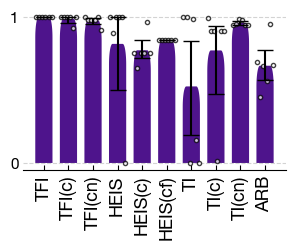

In [6]:
# ------------------ your plotting (drop-in) ------------------
import copy
font = "Helvetica Neue"
plt.rcParams.update({
    "text.usetex": False,   # Let Matplotlib handle fonts
    "font.family": "sans-serif",
    "font.sans-serif": [font,]
})
cm = 1/2.54  # centimeters in inches
pts_inch = 72.  # points in inches
# width = 15 * cm
# height = 7.5 * cm
width = 220 / pts_inch  # 1 column
height = 600 / pts_inch * (len(data_all_proc)/16) / 2  # half page

print("Figure size in points:", width*72, height*72)  # 1 inch = 72 points
print("Figure size in in:", width, height)  # 1 inch = 2.54 cm


full_data = []
best_i = []
for sub_folder in sub_folders_to_consider:
    full_data.append(data_all_proc.get(sub_folder, []))
    best_i.append(best_idcs.get(sub_folder, None))
#full_data = np.array(full_data)
  # just to demo multiple subplots


tick_params = {'axis': 'both', 'which': 'major', 'labelsize': 11, 'direction': 'in','labelleft':True,'labelbottom':True, 'labelright':False,
               'right': False, 'top': False, 'left': False, 'rotation': 90}
title_params = {'size': 11, 'x':0.5, 'y':1.1, 'ha':'center', 
                'bbox': None,}#dict(boxstyle="round,pad=0.1", fc="white", ec="black", lw=0.5, alpha=0.75)}
error_bar_params = {'error_lw': 1.5, 'error_cs': 6}
bar_params = dict(bar_width=0.7, bar_radius_fac=0.2)

y_lims = (-.05, 1.05)
single_point_size= 9

col1 = "#4e148c" # '#E63946'
col2 = '#fca311' 
col3 = '#929292'
bar_colors = [col1] * 10


fig, axs = plt.subplots(figsize=(width, height), ncols=1, nrows=1)

spec_tick_params_x = copy.deepcopy(tick_params)
spec_tick_params_y = copy.deepcopy(tick_params)
spec_tick_params_y['labelrotation'] = 0
spec_tick_params_y['axis'] = 'y'
spec_tick_params_y['labelsize'] = 11

spec_tick_params_x['labelsize'] = 13
spec_tick_params_x['axis'] = 'x'


x_label = "$F$"

sub_folders_to_consider = [
    "GROUND_TFIM",
    "GROUND_TFIM_VAR_COUPLING",
    "GROUND_TFIM_VAR_COUPLING_VAR_N",
    "GROUND_2D_HEISENBERG",
    "GROUND_2D_HEISENBERG_VAR",
    "GROUND_2D_HEISENBERG_TWO_VAR",
    "GROUND_TOPO_ISING",
    "GROUND_TOPO_ISING_VAR_COUPLING",
    "GROUND_TOPO_ISING_VAR_COUPLING_VAR_N",
    "GROUND_ARBITRARY",
]
x_tick_labels=[
    "TFI",
    "TFI(c)",
    "TFI(cn)",
    "HEIS",
    "HEIS(c)",
    "HEIS(cf)",
    "TI",
    "TI(c)",
    "TI(cn)",
    "ARB",
]
plot_data(axs, full_data, bar_colors=bar_colors, 
        tick_params_x=spec_tick_params_x, tick_params_y=spec_tick_params_y,
        title_params=title_params, bar_params=bar_params, error_bar_params=error_bar_params, ylims=y_lims,
        single_point_size=single_point_size, y_label="", x_tick_labels=x_tick_labels, y_ticks=[0., 1.])#, font_params=font_params)

axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.spines['left'].set_visible(False)
fig.tight_layout()
plt.savefig('quantum_ground_state_results.pdf', dpi=300, transparent=True)

# DYN tasks

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from scipy.stats import bootstrap  # if you used it earlier

def _rounded_top_bar(ax, x_left, y_bottom, width, height, facecolor,
                     radius, n_arc=12, zorder=2):
    """
    Draw a rectangle at (x_left, y_bottom) with given width and height,
    but round only the upper two corners with radius (data units).
    """
    # compute top and bottom in data coords (handles negative heights)
    top = max(y_bottom, y_bottom + height)
    bottom = min(y_bottom, y_bottom + height)
    h = top - bottom
    w = float(width)

    # degenerate: zero height or width -> draw plain rectangle
    if h <= 1e-12 or w <= 0:
        rect = plt.Rectangle((x_left, bottom), w, h,
                             facecolor=facecolor, edgecolor='none',
                             transform=ax.transData, zorder=zorder, clip_on=True)
        ax.add_patch(rect)
        return

    # clamp radius so it never exceeds half the width or half the height
    r = min(radius, w / 2.0, h / 2.0)
    if r <= 1e-12:
        rect = plt.Rectangle((x_left, bottom), w, h,
                             facecolor=facecolor, edgecolor='none',
                             transform=ax.transData, zorder=zorder, clip_on=True)
        ax.add_patch(rect)
        return

    verts = []
    codes = []

    # Start at bottom-left
    verts.append((x_left, bottom));            codes.append(Path.MOVETO)
    verts.append((x_left + w, bottom));        codes.append(Path.LINETO)
    verts.append((x_left + w, top - r));      codes.append(Path.LINETO)

    # top-right quarter circle (angles 0 -> pi/2), center = (x_left+w-r, top-r)
    cx_tr = x_left + w - r
    cy_tr = top - r
    ts = np.linspace(0.0, 0.5 * np.pi, n_arc)
    for t in ts:
        verts.append((cx_tr + r * np.cos(t), cy_tr + r * np.sin(t)))
        codes.append(Path.LINETO)

    # straight top edge (between the two corner arcs)
    verts.append((x_left + r, top)); codes.append(Path.LINETO)

    # top-left quarter circle (angles pi/2 -> pi), center = (x_left + r, top - r)
    cx_tl = x_left + r
    cy_tl = top - r
    ts = np.linspace(0.5 * np.pi, np.pi, n_arc)
    for t in ts:
        verts.append((cx_tl + r * np.cos(t), cy_tl + r * np.sin(t)))
        codes.append(Path.LINETO)

    # close back to bottom-left
    verts.append((x_left, bottom)); codes.append(Path.CLOSEPOLY)

    path = Path(verts, codes)
    patch = PathPatch(path, facecolor=facecolor, edgecolor='none',
                      transform=ax.transData, zorder=zorder, clip_on=True)
    ax.add_patch(patch)

def plot_data(ax, data, x_tick_labels=None, y_label=None, title=None, bar_colors=None, tick_params_x=None, tick_params_y=None, title_params=None,
              bar_params=None, error_bar_params=None, ylims=None, single_point_size=18, y_ticks=None,):
    
    if not bar_params:
        bar_params = dict()
    if not error_bar_params:
        error_bar_params = dict()
    bar_width = bar_params.get('bar_width', 0.4)
    bar_radius_fac = bar_params.get('bar_radius_fac', 0.18)

    error_lw = error_bar_params.get('error_lw', 1.5)
    error_cs = error_bar_params.get('error_cs', 6)

    if not bar_colors:
    #     # default safe colors
        bar_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"][:len(data)]

    x_positions = np.arange(len(data))
    #bar_width = 0.4

    means, cis_lower, cis_upper = [], [], []
    ci = 0.90

    for i, values in enumerate(data):
        mean = average_func(values)
        if np.size(values) > 1:
            res = bootstrap((np.asarray(values),), average_func,
                            confidence_level=ci, n_resamples=10000,
                            method='percentile', random_state=42)
            ci_low, ci_high = res.confidence_interval
        else:
            ci_low, ci_high = mean, mean

        means.append(mean)
        cis_lower.append(mean - ci_low)
        cis_upper.append(ci_high - mean)

        # jittered scatter of raw points (centered on the bar)
        spread = np.linspace(-bar_width / 2.2, bar_width / 2.2, len(values))
        ax.scatter(x_positions[i] + spread, values, s=single_point_size, c='white', alpha=0.75, zorder=5,
                   edgecolor='black', linewidth=1.)

    # Draw rounded-top bars (we draw the patches ourselves) and then errorbars on top
    radius = bar_width * bar_radius_fac  # tweak this fraction to taste (data units)
    for i in range(len(data)):
        x_left = x_positions[i] - bar_width / 2.0
        # bars are anchored at y=0 just like ax.bar defaults (change if you use a different baseline)
        _rounded_top_bar(ax, x_left, -1.0, bar_width, means[i]+1.0,
                        facecolor=bar_colors[i], radius=radius, n_arc=14, zorder=2)

    # draw errorbars on top (so caps and whiskers are not obscured)
    for i in range(len(data)):
        ax.errorbar(x_positions[i], means[i],
                    yerr=[[cis_lower[i]], [cis_upper[i]]],
                    fmt='none', ecolor='k', elinewidth=error_lw, capsize=error_cs, zorder=10)

    # Style polish
    ax.grid(True, linestyle='--', alpha=0.55, axis='y')
    #ax.set_axisbelow(True)
    ax.set_xticks(x_positions)
    if x_tick_labels:
        ax.set_xticklabels(x_tick_labels, fontsize=tick_params_x.get('labelsize', 10))
    
    ax.set_ylabel(y_label, fontsize=tick_params_y.get('labelsize', 10))
    #ax.set_title(title)
    if title:
        ax.text(s=title, zorder=100, **title_params)
    # for spine in ('top', 'right'):
    #     ax.spines[spine].set_visible(False)
    
    if tick_params_x:
        ax.tick_params(**tick_params_x)
    if tick_params_y:
        ax.tick_params(**tick_params_y)
   # ax.tick_params(axis='y', rotation=0)
    if ylims:
        ax.set_ylim(ylims)
    if y_ticks is not None:
        ax.set_yticks(y_ticks)
    #ax.tick_params(labelleft=False)

In [8]:
saved_paths = ['./quantum_dynamics_final_runs', './quantum_gs_final_runs']
contained_in_name = 'run'
contained_in_compare = 'comparison'
average_func = np.mean
sub_folders_to_consider = [
    "DYNAMICS_ARBITRARY_THREE_SPINS",
    "DYNAMICS_ARBITRARY_THREE_SPINS_TWO_SPINS_ACCESS",
    "DYNAMICS_ARBITRARY_THREE_SPINS_TWO_SPINS_ACCESS_VAR_FIELD",
    "DYNAMICS_HEISENBERG",
    "DYNAMICS_HEISENBERG_VAR_FIELD",
    "DYNAMICS_HEISENBERG_VAR_FIELD_TWO_SPINS_ACCESS",
    "DYNAMICS_TFIM_VAR_COUPLING",
    "DYNAMICS_TFIM_VAR_COUPLING_TWO_SPINS_ACCESS",
]

In [9]:
normal_fidelity = False # plot Fidelity if True else 1/N log(Fidelity)
log10 = False

data_all_unproc = {}
best_idcs = {}
for saved_path in saved_paths[:]:
    for sub_folder in sub_folders_to_consider:
        # if not os.path.exists(os.path.join(saved_path, sub_folder)):
        #     data_all_unproc[sub_folder] = []
        #     best_idcs[sub_folder] = None
        #     continue
        if not os.path.exists(os.path.join(saved_path, sub_folder)):
            continue
        folders = os.listdir(os.path.join(saved_path, sub_folder))
        filtered_files = sorted([os.path.join(saved_path, sub_folder, f) for f in folders if contained_in_name in f])
        data_unproc = [extract_metric(f, 'fidelity', normal_fidelity=normal_fidelity) for f in filtered_files]
        data_all_unproc[sub_folder] = data_unproc


for sub_folder in sub_folders_to_consider:
    if sub_folder not in data_all_unproc:
        data_all_unproc[sub_folder] = []


data_all_proc= {}
for key, data in data_all_unproc.items():
    min_clip = 0.
    #    data_all_proc[key] = data
    data_all_proc[key] = np.clip(np.nan_to_num(data, nan=-1., posinf=-1., neginf=-1.), min_clip, 1.)

Figure size in points: 220.0 187.50000000000003
Figure size in in: 3.0555555555555554 2.604166666666667


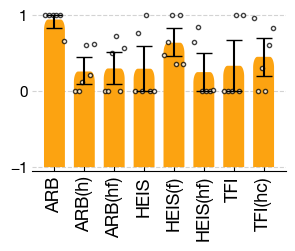

In [10]:
# ------------------ your plotting (drop-in) ------------------
import copy
font = "Helvetica Neue"
plt.rcParams.update({
    "text.usetex": False,   # Let Matplotlib handle fonts
    "font.family": "sans-serif",
    "font.sans-serif": [font,]
})
cm = 1/2.54  # centimeters in inches
pts_inch = 72.  # points in inches
# width = 15 * cm
# height = 7.5 * cm
width = 220 / pts_inch  # 1 column
height = 600 / pts_inch * ((len(data_all_proc)+2)/16) / 2  # half page

print("Figure size in points:", width*72, height*72)  # 1 inch = 72 points
print("Figure size in in:", width, height)  # 1 inch = 2.54 cm


full_data = []
best_i = []
for sub_folder in sub_folders_to_consider:
    full_data.append(data_all_proc.get(sub_folder, []))
    best_i.append(best_idcs.get(sub_folder, None))


tick_params = {'axis': 'both', 'which': 'major', 'labelsize': 11, 'direction': 'in','labelleft':True,'labelbottom':True, 'labelright':False,
               'right': False, 'top': False, 'left': False, 'rotation': 90}
title_params = {'size': 11, 'x':0.5, 'y':1.1, 'ha':'center', 
                'bbox': None,}#dict(boxstyle="round,pad=0.1", fc="white", ec="black", lw=0.5, alpha=0.75)}
error_bar_params = {'error_lw': 1.5, 'error_cs': 6}
bar_params = dict(bar_width=0.7, bar_radius_fac=0.2)

y_lims = (-1.05, 1.05)
single_point_size= 9

col1 = "#4e148c" # '#E63946'
col2 = '#fca311' 
col3 = '#929292'
bar_colors = [col2] * 10


fig, axs = plt.subplots(figsize=(width, height), ncols=1, nrows=1)

spec_tick_params_x = copy.deepcopy(tick_params)
spec_tick_params_y = copy.deepcopy(tick_params)
spec_tick_params_y['labelrotation'] = 0
spec_tick_params_y['axis'] = 'y'
spec_tick_params_y['labelsize'] = 11

spec_tick_params_x['labelsize'] = 13
spec_tick_params_x['axis'] = 'x'


x_label = "$F$"
subs = [
    "DYNAMICS_ARBITRARY_THREE_SPINS",
    "DYNAMICS_ARBITRARY_THREE_SPINS_TWO_SPINS_ACCESS",
    "DYNAMICS_ARBITRARY_THREE_SPINS_TWO_SPINS_ACCESS_VAR_FIELD",
    "DYNAMICS_HEISENBERG",
    "DYNAMICS_HEISENBERG_VAR_FIELD",
    "DYNAMICS_HEISENBERG_VAR_FIELD_TWO_SPINS_ACCESS",
    "DYNAMICS_TFIM_VAR_COUPLING",
    "DYNAMICS_TFIM_VAR_COUPLING_TWO_SPINS_ACCESS",
]
x_tick_labels=[
    "ARB",
    "ARB(h)",
    "ARB(hf)",
    "HEIS",
    "HEIS(f)",
    "HEIS(hf)",
    "TFI",
    "TFI(hc)",
]
full_data_plot = full_data
plot_data(axs, full_data_plot, bar_colors=bar_colors, 
        tick_params_x=spec_tick_params_x, tick_params_y=spec_tick_params_y,
        title_params=title_params, bar_params=bar_params, error_bar_params=error_bar_params, ylims=y_lims,
        single_point_size=single_point_size, y_label="", x_tick_labels=x_tick_labels, y_ticks=[-1., 0., 1.])#, font_params=font_params)

axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.spines['left'].set_visible(False)
fig.tight_layout()
plt.savefig('quantum_dynamics_results.pdf', dpi=300, transparent=True)